In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import re
import numpy as np

from fitter import Fitter, get_common_distributions, get_distributions
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.datasets import make_friedman3, make_s_curve
from sklearn.linear_model import BayesianRidge, ElasticNet
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

!pip install imbalanced-learn
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import cohen_kappa_score

# for Box-Cox Transformation
from scipy import stats

# plotting modules
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.express as px

from tqdm import tqdm
import math

from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame

#Multilabel Stratified K Fold Creation
!pip install iterative-stratification
import sys
sys.path.append('../input/iterative-stratification/iterative-stratification-master')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#Collect data from sensors (i.e., time-series data) installed in the manufacturing system 
ai4i2020_encoded_balanced=pd.read_csv(r'G:\\.shortcut-targets-by-id\\1-wapAl6N5YrCs68c4NiFKyvybXTXmdgZ\\Ph_D_Tyrovolas\\Our Papers\\3rd_Paper-Proposal\\Testbed Codes\\AI4I_Case_Study\\raw_data\\ai4i2020_encoded_balanced.csv')
ai4i2020_encoded_balanced.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,0,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,0,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,0,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,0,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [3]:
# Run in local
# Fold index
fold = 1

original_X_train = pd.read_csv('G:\\.shortcut-targets-by-id\\1-wapAl6N5YrCs68c4NiFKyvybXTXmdgZ\\Ph_D_Tyrovolas\\Our Papers\\3rd_Paper-Proposal\\Testbed Codes\\AI4I_Case_Study\\k-fold cross validation datasets\\' + str(fold) + "\\Training Dataset" + "\\X_train_iter_" + str(fold) + ".csv")
original_X_test = pd.read_csv('G:\\.shortcut-targets-by-id\\1-wapAl6N5YrCs68c4NiFKyvybXTXmdgZ\\Ph_D_Tyrovolas\\Our Papers\\3rd_Paper-Proposal\\Testbed Codes\\AI4I_Case_Study\\k-fold cross validation datasets\\' + str(fold) + "\\Test Dataset" + "\\X_test_iter_" + str(fold) + ".csv")

X_train = pd.read_csv('G:\\.shortcut-targets-by-id\\1-wapAl6N5YrCs68c4NiFKyvybXTXmdgZ\\Ph_D_Tyrovolas\\Our Papers\\3rd_Paper-Proposal\\Testbed Codes\\AI4I_Case_Study\\k-fold cross validation datasets\\' + str(fold) + "\\Training Dataset" + "\\Scaled_X_train_iter_" + str(fold) + ".csv", names=['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'])
y_train = pd.read_csv('G:\\.shortcut-targets-by-id\\1-wapAl6N5YrCs68c4NiFKyvybXTXmdgZ\\Ph_D_Tyrovolas\\Our Papers\\3rd_Paper-Proposal\\Testbed Codes\\AI4I_Case_Study\\k-fold cross validation datasets\\' + str(fold) + "\\Training Dataset" + "\\y_train_iter_" + str(fold) + ".csv")
X_test = pd.read_csv('G:\\.shortcut-targets-by-id\\1-wapAl6N5YrCs68c4NiFKyvybXTXmdgZ\\Ph_D_Tyrovolas\\Our Papers\\3rd_Paper-Proposal\\Testbed Codes\\AI4I_Case_Study\\k-fold cross validation datasets\\' + str(fold) + "\\Test Dataset" + "\\Scaled_X_test_iter_" + str(fold) + ".csv", names=['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'])
y_test = pd.read_csv('G:\\.shortcut-targets-by-id\\1-wapAl6N5YrCs68c4NiFKyvybXTXmdgZ\\Ph_D_Tyrovolas\\Our Papers\\3rd_Paper-Proposal\\Testbed Codes\\AI4I_Case_Study\\k-fold cross validation datasets\\' + str(fold) + "\\Test Dataset" + "\\y_test_iter_" + str(fold) + ".csv")

In [4]:
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [5]:
acc_list = []
auc_list = []
kappa_list = []

## Fuzzy Cognitive Map

In [6]:
from numpy import genfromtxt
y_train_pred_fcm = genfromtxt(r'G:\\.shortcut-targets-by-id\\1-wapAl6N5YrCs68c4NiFKyvybXTXmdgZ\\Ph_D_Tyrovolas\\Our Papers\\3rd_Paper-Proposal\\Testbed Codes\\AI4I_Case_Study\\k-fold cross validation datasets\\' + str(fold) + "\\Training Dataset" + "\\y_train_pred_fcm.csv", delimiter=',')
y_test_pred_fcm = genfromtxt(r'G:\\.shortcut-targets-by-id\\1-wapAl6N5YrCs68c4NiFKyvybXTXmdgZ\\Ph_D_Tyrovolas\\Our Papers\\3rd_Paper-Proposal\\Testbed Codes\\AI4I_Case_Study\\k-fold cross validation datasets\\' + str(fold) + "\\Test Dataset" + "\\y_test_pred_fcm.csv", delimiter=',')
fcm_pred_class_train = genfromtxt(r'G:\\.shortcut-targets-by-id\\1-wapAl6N5YrCs68c4NiFKyvybXTXmdgZ\\Ph_D_Tyrovolas\\Our Papers\\3rd_Paper-Proposal\\Testbed Codes\\AI4I_Case_Study\\k-fold cross validation datasets\\' + str(fold) + "\\Training Dataset" + "\\fcm_pred_class_train.csv", delimiter=',')
fcm_pred_class_test = genfromtxt(r'G:\\.shortcut-targets-by-id\\1-wapAl6N5YrCs68c4NiFKyvybXTXmdgZ\\Ph_D_Tyrovolas\\Our Papers\\3rd_Paper-Proposal\\Testbed Codes\\AI4I_Case_Study\\k-fold cross validation datasets\\' + str(fold) + "\\Test Dataset" + "\\fcm_pred_class_test.csv", delimiter=',')

<AxesSubplot:>

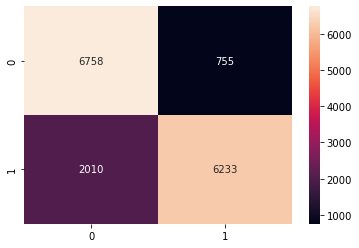

In [7]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, fcm_pred_class_train)
sns.heatmap(confusion_matrix(y_train, fcm_pred_class_train), annot=True,fmt='d')

In [8]:
#Performance measures for training dataset

from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score
print("Precision Score: ",precision_score(y_train,fcm_pred_class_train))
print("Recall Score: ",recall_score(y_train, fcm_pred_class_train))
print("F1 Score: ",f1_score(y_train, fcm_pred_class_train))
print("Accuracy Score: ",accuracy_score(y_train, fcm_pred_class_train))

Precision Score:  0.8919576416714368
Recall Score:  0.7561567390513163
F1 Score:  0.8184623465301032
Accuracy Score:  0.8245112972835745


#### Evaluating on Test set 

In [9]:
from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score

print("Precision Score: ",precision_score(y_test, fcm_pred_class_test))
print("Recall Score: ",recall_score(y_test, fcm_pred_class_test))
print("F1 Score: ",f1_score(y_test, fcm_pred_class_test))
print("Accuracy Score: ",accuracy_score(y_test, fcm_pred_class_test))

Precision Score:  0.8835534213685474
Recall Score:  0.8034934497816594
F1 Score:  0.8416237850200115
Accuracy Score:  0.8418046830382638


In [10]:
#calculate AUC of model
from sklearn import metrics
auc_fcm = metrics.roc_auc_score(y_test, y_test_pred_fcm)
print(auc_fcm)

0.8755667703893523


In [11]:
cohen_score_fcm = cohen_kappa_score(y_test, fcm_pred_class_test)
cohen_score_fcm

0.6843182597727349

In [12]:
acc_list.append(metrics.accuracy_score(y_test, fcm_pred_class_test))
auc_list.append(auc_fcm)
kappa_list.append(cohen_score_fcm)

## LightGBM

In [13]:
# build the lightgbm model
import lightgbm as lgb
lgbmc_clf = lgb.LGBMClassifier()
lgbmc_clf.fit(X_train, y_train.values.ravel())

LGBMClassifier()

In [14]:
#Predict the response for train dataset
y_train_pred_lgbmc = lgbmc_clf.predict(X_train)

print("LightGBM Classifier score: ",lgbmc_clf.score(X_train, y_train))

LightGBM Classifier score:  0.9996826605737497


<AxesSubplot:>

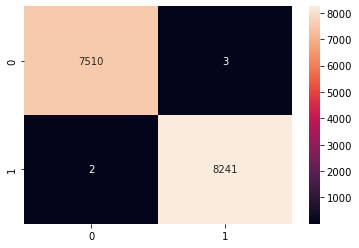

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred_lgbmc)
sns.heatmap(confusion_matrix(y_train, y_train_pred_lgbmc), annot=True,fmt='d')

In [16]:
#Performance measures for training dataset

from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score
print("Precision Score: ",precision_score(y_train,y_train_pred_lgbmc))
print("Recall Score: ",recall_score(y_train, y_train_pred_lgbmc))
print("F1 Score: ",f1_score(y_train, y_train_pred_lgbmc))
print("Accuracy Score: ",accuracy_score(y_train, y_train_pred_lgbmc))

Precision Score:  0.9996360989810772
Recall Score:  0.9997573698896033
F1 Score:  0.9996967307575666
Accuracy Score:  0.9996826605737497


#### Evaluating on Test set 

In [17]:
from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score

#Predict the response for test dataset
y_test_pred_lgbmc = lgbmc_clf.predict(X_test)


print("Precision Score: ",precision_score(y_test, y_test_pred_lgbmc))
print("Recall Score: ",recall_score(y_test, y_test_pred_lgbmc))
print("F1 Score: ",f1_score(y_test, y_test_pred_lgbmc))
print("Accuracy Score: ",accuracy_score(y_test, y_test_pred_lgbmc))

Precision Score:  0.9859154929577465
Recall Score:  0.9934497816593887
F1 Score:  0.9896682979880369
Accuracy Score:  0.989149057681325


In [18]:
from sklearn import metrics
#calculate AUC of model
auc_lgbmc = metrics.roc_auc_score(y_test, y_test_pred_lgbmc)
print(auc_lgbmc)

0.9889404596919699


In [19]:
cohen_score_lgbmc = cohen_kappa_score(y_test, y_test_pred_lgbmc)

In [20]:
acc_list.append(accuracy_score(y_test, y_test_pred_lgbmc))
auc_list.append(auc_lgbmc)
kappa_list.append(cohen_score_lgbmc)

## RIPPER

In [21]:
!pip install wittgenstein


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
import wittgenstein as lw
ripper_clf = lw.RIPPER() # Or irep_clf = lw.IREP() to build a model using IREP
ripper_clf.fit(X_train, y_train.values.ravel()) # Or pass X and y data to .fit
ripper_clf

<RIPPER(verbosity=0, max_total_conds=None, n_discretize_bins=10, dl_allowance=64, prune_size=0.33, k=2, random_state=None, max_rules=None, max_rule_conds=None) with fit ruleset>

The model predicts positive class if any of the inner-nested condition-combinations are all true.  The word that you will often see that indicates a union is "or" and intersection is "and"

In [23]:
ripper_clf.out_model()

[[Type=0.0348969159415116 ^ Rotationalspeedrpm=0.16-0.24 ^ Toolwearmin=0.83-0.86] V
[Type=0.0348969159415116 ^ TorqueNm=>0.89 ^ Rotationalspeedrpm=<0.16 ^ Toolwearmin=0.76-0.83] V
[Type=0.0348969159415116 ^ Toolwearmin=>0.86 ^ TorqueNm=0.61-0.71] V
[TorqueNm=>0.89 ^ Toolwearmin=<0.12] V
[TorqueNm=0.8-0.89] V
[TorqueNm=>0.89 ^ Toolwearmin=0.38-0.49] V
[Rotationalspeedrpm=0.29-0.34] V
[TorqueNm=>0.89 ^ Toolwearmin=0.27-0.38] V
[Toolwearmin=>0.86 ^ TorqueNm=0.71-0.8] V
[Type=0.0348969159415116 ^ Rotationalspeedrpm=0.24-0.29 ^ AirtemperatureK=0.81-0.87] V
[Rotationalspeedrpm=0.16-0.24 ^ Type=0.0348969159415116 ^ AirtemperatureK=0.81-0.87 ^ ProcesstemperatureK=0.61-0.7] V
[Toolwearmin=>0.86 ^ Rotationalspeedrpm=<0.16] V
[Rotationalspeedrpm=0.16-0.24 ^ Type=0.0348969159415116 ^ TorqueNm=>0.89 ^ Toolwearmin=0.12-0.18] V
[Rotationalspeedrpm=0.16-0.24 ^ Type=0.0348969159415116 ^ AirtemperatureK=0.76-0.81] V
[Toolwearmin=>0.86 ^ TorqueNm=0.51-0.61] V
[TorqueNm=>0.89 ^ Toolwearmin=0.76-0.83] V
[R

In [24]:
from sklearn.metrics import precision_score, recall_score

y_train_pred_ripper = ripper_clf.predict(X_train)

#Default scoring metric is accuracy.
accuracy = ripper_clf.score(X_train,  y_train.values.ravel())
precision = ripper_clf.score(X_train,  y_train.values.ravel())
recall = ripper_clf.score(X_train,  y_train.values.ravel())
cond_count = ripper_clf.ruleset_.count_conds()
print(f'accuracy: {accuracy} precision: {precision} recall: {recall} conds: {cond_count}')

accuracy: 0.5746382330540747 precision: 0.5746382330540747 recall: 0.5746382330540747 conds: 120


<AxesSubplot:>

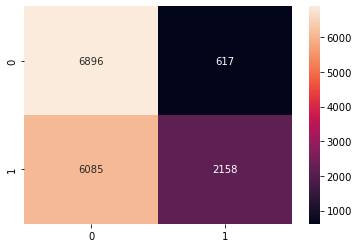

In [25]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred_ripper)
sns.heatmap(confusion_matrix(y_train, y_train_pred_ripper), annot=True,fmt='d')

#### Evaluating on Test set 

In [26]:
from sklearn.metrics import precision_score, recall_score

y_test_pred_ripper = ripper_clf.predict(X_test)

#Default scoring metric is accuracy.
accuracy = ripper_clf.score(X_test,  y_test.values.ravel())
precision = ripper_clf.score(X_test, y_test.values.ravel(), precision_score)
recall = ripper_clf.score(X_test, y_test.values.ravel(), recall_score)
cond_count = ripper_clf.ruleset_.count_conds()
print(f'accuracy: {accuracy} precision: {precision} recall: {recall} conds: {cond_count}')

accuracy: 0.806967447173044 precision: 0.9002770083102493 recall: 0.7096069868995634 conds: 120


In [27]:
from sklearn import metrics
#calculate AUC of model
auc_ripper = metrics.roc_auc_score(y_test, y_test_pred_ripper)
print(auc_ripper)

0.8116897209946918


In [28]:
cohen_score_ripper = cohen_kappa_score(y_test, y_test_pred_ripper)

In [29]:
acc_list.append(accuracy)
auc_list.append(auc_ripper)
kappa_list.append(cohen_score_ripper)

We can also ask our model to tell us why it made each positive prediction that it did:

In [30]:
#ripper_clf.predict(X_test, give_reasons=True)

## K-Nearest Neighbour (KNN)

In [31]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train.values.ravel())

KNeighborsClassifier()

In [32]:
#Predict the response for train dataset
y_train_pred_knn = knn.predict(X_train)

print("K-Nearest Neighbour score: ",knn.score(X_train, y_train))

K-Nearest Neighbour score:  0.9701700939324702


<AxesSubplot:>

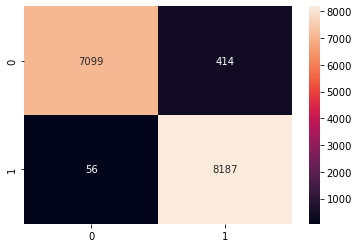

In [33]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred_knn)
sns.heatmap(confusion_matrix(y_train, y_train_pred_knn), annot=True,fmt='d')

In [34]:
#Performance measures for training dataset

from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score
print("Precision Score: ",precision_score(y_train,y_train_pred_knn))
print("Recall Score: ",recall_score(y_train, y_train_pred_knn))
print("F1 Score: ",f1_score(y_train, y_train_pred_knn))
print("Accuracy Score: ",accuracy_score(y_train, y_train_pred_knn))

Precision Score:  0.9518660620858039
Recall Score:  0.9932063569088924
F1 Score:  0.9720968890999762
Accuracy Score:  0.9701700939324702


#### Evaluating on Test set 

In [35]:
from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score

#Predict the response for test dataset
y_test_pred_knn = knn.predict(X_test)


print("Precision Score: ",precision_score(y_test, y_test_pred_knn))
print("Recall Score: ",recall_score(y_test, y_test_pred_knn))
print("F1 Score: ",f1_score(y_test, y_test_pred_knn))
print("Accuracy Score: ",accuracy_score(y_test, y_test_pred_knn))

Precision Score:  0.9496327387198321
Recall Score:  0.9879912663755459
F1 Score:  0.9684323167469235
Accuracy Score:  0.9663049685893775


In [36]:
from sklearn import metrics
#calculate AUC of model
auc_knn = metrics.roc_auc_score(y_test, y_test_pred_knn)
print(auc_knn)

0.9652531182177131


In [37]:
cohen_score_knn = cohen_kappa_score(y_test, y_test_pred_knn)

In [38]:
acc_list.append(accuracy_score(y_test, y_test_pred_knn))
auc_list.append(auc_knn)
kappa_list.append(cohen_score_knn)

## Decision Tree 

In [39]:
# Create Decision Tree classifer object
dt_clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
dt_clf = dt_clf.fit(X_train,y_train.values.ravel())

In [40]:
#Predict the response for train dataset
y_train_pred_dt = dt_clf.predict(X_train)

print("Decision Tree score: ",dt_clf.score(X_train, y_train))

Decision Tree score:  1.0


<AxesSubplot:>

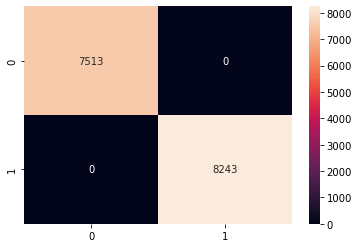

In [41]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred_dt)
sns.heatmap(confusion_matrix(y_train, y_train_pred_dt), annot=True,fmt='d')

In [42]:
#Performance measures for training dataset

from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score
print("Precision Score: ",precision_score(y_train,y_train_pred_dt))
print("Recall Score: ",recall_score(y_train, y_train_pred_dt))
print("F1 Score: ",f1_score(y_train, y_train_pred_dt))
print("Accuracy Score: ",accuracy_score(y_train, y_train_pred_dt))

Precision Score:  1.0
Recall Score:  1.0
F1 Score:  1.0
Accuracy Score:  1.0


#### Evaluating on Test set 

In [43]:
from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score

#Predict the response for test dataset
y_test_pred_dt = dt_clf.predict(X_test)


print("Precision Score: ",precision_score(y_test, y_test_pred_dt))
print("Recall Score: ",recall_score(y_test, y_test_pred_dt))
print("F1 Score: ",f1_score(y_test, y_test_pred_dt))
print("Accuracy Score: ",accuracy_score(y_test, y_test_pred_dt))

Precision Score:  0.9835706462212487
Recall Score:  0.980349344978166
F1 Score:  0.9819573537452159
Accuracy Score:  0.9811536264991434


In [44]:
from sklearn import metrics
#calculate AUC of model
auc_dt = metrics.roc_auc_score(y_test, y_test_pred_dt)
print(auc_dt)

0.9811926365609391


In [45]:
cohen_score_dt = cohen_kappa_score(y_test, y_test_pred_dt)

In [46]:
acc_list.append(accuracy_score(y_test, y_test_pred_dt))
auc_list.append(auc_dt)
kappa_list.append(cohen_score_dt)

## Artificial Neural Network

In [47]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

# for modeling
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [48]:
# build a model
model = Sequential()
model.add(Dense(16, input_shape=(X_train.shape[1],), activation='relu')) # Add an input shape! (features,)
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

# compile the model
model.compile(optimizer='Adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = EarlyStopping(monitor='val_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=10,
                                   restore_best_weights=True)

# now we just update our model fit call
history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=80, # you can set this to a big number!
                    batch_size=10,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                112       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
1261/1261 [==============================] - 2s 1ms/step - loss: 0.4497 - accuracy: 0.8006 - val_loss: 0.3239 - val_accuracy: 0.8699
Epoch 2/80
1261/1261 [==============================] - 1s 1ms/step - loss: 0.3025 - accuracy: 0.8689 - val_loss: 0.2780 - val_accuracy: 0.8791
Epoch 3/80
1261/1261 [============

In [49]:
#Predict the response for train dataset
y_train_pred_ann = model.predict(X_train)

print("Artificial Neural Network score: ",model.evaluate(X_train, y_train))

493/493 [==============================] - 0s 841us/step - loss: 0.1395 - accuracy: 0.9569
Artificial Neural Network score:  [0.1394713819026947, 0.9569053053855896]


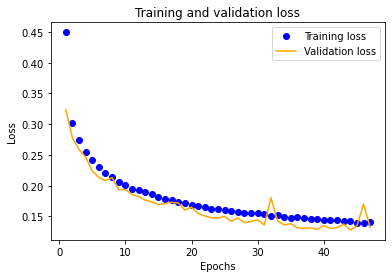

In [50]:

history_dict = history.history
# Learning curve(Loss)
# let's see the training and validation loss by epoch

# loss
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this

# range of X (no. of epochs)
epochs = range(1, len(loss_values) + 1) 

# plot
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

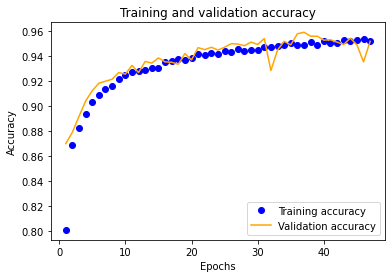

0.9593908786773682

In [51]:
# Learning curve(accuracy)
# let's see the training and validation accuracy by epoch

# accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "bo" is for "blue dot"
plt.plot(epochs, acc, 'bo', label='Training accuracy')
# orange is for "orange"
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# this is the max value - should correspond to
# the HIGHEST train accuracy
np.max(val_acc)

In [52]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# see how these are numbers between 0 and 1? 
model.predict(X_train) # prob of successes (survival)
np.round(model.predict(X_train),0) # 1 and 0 (survival or not)
y_train # 1 and 0 (survival or not)

# so we need to round to a whole number (0 or 1),
# or the confusion matrix won't work!
preds = np.round(model.predict(X_train),0)

# confusion matrix
print(confusion_matrix(y_train, preds)) # order matters! (actual, predicted)

print(classification_report(y_train, preds))

[[7070  443]
 [ 236 8007]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      7513
           1       0.95      0.97      0.96      8243

    accuracy                           0.96     15756
   macro avg       0.96      0.96      0.96     15756
weighted avg       0.96      0.96      0.96     15756



#### Evaluating on Test set

In [53]:
# see how these are numbers between 0 and 1? 
model.predict(X_test) # prob of successes (survival)
np.round(model.predict(X_test),0) # 1 and 0 (survival or not)
y_test # 1 and 0 (survival or not)

# so we need to round to a whole number (0 or 1),
# or the confusion matrix won't work!
preds = np.round(model.predict(X_test),0)

# confusion matrix
print(confusion_matrix(y_test, preds)) # order matters! (actual, predicted)

print(classification_report(y_test, preds))

[[790  45]
 [ 32 884]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       835
           1       0.95      0.97      0.96       916

    accuracy                           0.96      1751
   macro avg       0.96      0.96      0.96      1751
weighted avg       0.96      0.96      0.96      1751



In [54]:
#calculate AUC of model
from sklearn import metrics
auc_ann = metrics.roc_auc_score(y_test, model.predict(X_test))
print(auc_ann)

0.9868773370289987


In [55]:
cohen_score_ann = cohen_kappa_score(y_test, preds)

In [56]:
acc_list.append(metrics.accuracy_score(y_test, preds))
auc_list.append(metrics.roc_auc_score(y_test, model.predict(X_test)))
kappa_list.append(cohen_score_ann)

## Support Vector Machine

In [57]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
svm_clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
svm_clf.fit(X_train, y_train.values.ravel())

SVC(kernel='linear')

In [58]:
#Predict the response for train dataset
y_train_pred_svm = svm_clf.predict(X_train)

print("Support Vector Machine score: ",svm_clf.score(X_train, y_train))

Support Vector Machine score:  0.8378395531860878


<AxesSubplot:>

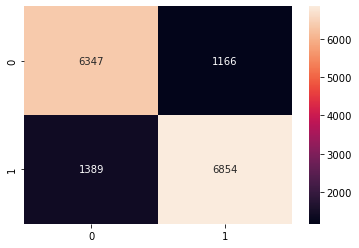

In [59]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred_svm)
sns.heatmap(confusion_matrix(y_train, y_train_pred_svm), annot=True,fmt='d')

In [60]:
#Performance measures for training dataset

from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score
print("Precision Score: ",precision_score(y_train, y_train_pred_svm))
print("Recall Score: ",recall_score(y_train, y_train_pred_svm))
print("F1 Score: ",f1_score(y_train, y_train_pred_svm))
print("Accuracy Score: ",accuracy_score(y_train, y_train_pred_svm))

Precision Score:  0.8546134663341646
Recall Score:  0.8314933883294917
F1 Score:  0.8428949148373608
Accuracy Score:  0.8378395531860878


#### Evaluating on Test set


In [61]:
from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score

#Predict the response for test dataset
y_test_pred_svm = svm_clf.predict(X_test)
#y_test_pred_sgd = sgd_clf.predict(X_test)

print("Precision Score: ",precision_score(y_test, y_test_pred_svm))
print("Recall Score: ",recall_score(y_test, y_test_pred_svm))
print("F1 Score: ",f1_score(y_test, y_test_pred_svm))
print("Accuracy Score: ",accuracy_score(y_test, y_test_pred_svm))

Precision Score:  0.8504366812227074
Recall Score:  0.8504366812227074
F1 Score:  0.8504366812227074
Accuracy Score:  0.8435179897201599


In [62]:
from sklearn import metrics
#calculate AUC of model
auc_svm = metrics.roc_auc_score(y_test, y_test_pred_svm)
print(auc_svm)

0.8431824124676411


In [63]:
cohen_score_svm = cohen_kappa_score(y_test, y_test_pred_svm)

In [64]:
acc_list.append(accuracy_score(y_test, y_test_pred_svm))
auc_list.append(auc_svm)
kappa_list.append(cohen_score_svm)

## Gaussian Naive Bayes Classifier

In [65]:
%%time
from sklearn.naive_bayes import GaussianNB

nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train.values.ravel())

Wall time: 5.98 ms


GaussianNB()

#### Evaluating on Training Set

In [66]:
#Predict the response for train dataset
y_train_pred_nb = nb_clf.predict(X_train)

print("Naive Bayes score: ",nb_clf.score(X_train, y_train))

Naive Bayes score:  0.8285732419395786


<AxesSubplot:>

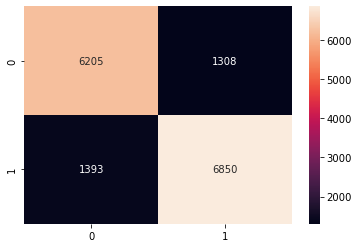

In [67]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred_nb)
sns.heatmap(confusion_matrix(y_train, y_train_pred_nb), annot=True,fmt='d')

In [68]:
#Performance measures for training dataset

from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score
print("Precision Score: ",precision_score(y_train, y_train_pred_nb))
print("Recall Score: ",recall_score(y_train, y_train_pred_nb))
print("F1 Score: ",f1_score(y_train, y_train_pred_nb))
print("Accuracy Score: ",accuracy_score(y_train, y_train_pred_nb))

Precision Score:  0.839666584947291
Recall Score:  0.8310081281086983
F1 Score:  0.835314919821962
Accuracy Score:  0.8285732419395786


### Fine Tuning for Gaussian Naive Bayes

In [69]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

NB_distribution = {'var_smoothing': np.logspace(0,-9, num=100)}

nb_clf = GaussianNB()       

rnd_search_nb = RandomizedSearchCV(nb_clf, param_distributions = NB_distribution, random_state = 42) 
rnd_search_nb.fit(X_train, y_train.values.ravel()) 

Wall time: 307 ms


RandomizedSearchCV(estimator=GaussianNB(),
                   param_distributions={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.8480358...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
                   random_state=42)

In [70]:
cvres = pd.DataFrame(rnd_search_nb.cv_results_).sort_values(by=['rank_test_score'])
for mean_score, params,rank in zip(cvres["mean_test_score"], cvres["params"],cvres["rank_test_score"]):
    print("Rank {}# - Score: {} - {}".format(rank, np.sqrt(mean_score), params))

Rank 1# - Score: 0.9102954324430825 - {'var_smoothing': 2.848035868435799e-08}
Rank 1# - Score: 0.9102954324430825 - {'var_smoothing': 1.5199110829529332e-05}
Rank 1# - Score: 0.9102954324430825 - {'var_smoothing': 4.3287612810830526e-07}
Rank 1# - Score: 0.9102954324430825 - {'var_smoothing': 8.111308307896872e-05}
Rank 1# - Score: 0.9102954324430825 - {'var_smoothing': 0.0001}
Rank 1# - Score: 0.9102954324430825 - {'var_smoothing': 0.0002848035868435802}
Rank 1# - Score: 0.9102954324430825 - {'var_smoothing': 5.336699231206302e-08}
Rank 8# - Score: 0.9099118325432533 - {'var_smoothing': 0.01}
Rank 9# - Score: 0.9077818998940024 - {'var_smoothing': 0.12328467394420659}
Rank 10# - Score: 0.8995645141853625 - {'var_smoothing': 1.0}


In [71]:
rnd_search_nb.best_estimator_

GaussianNB(var_smoothing=2.848035868435799e-08)

#### Evaluating on Test set

In [72]:
from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score

#Predict the response for test dataset
#y_test_pred_nb = nb_clf.predict(X_test)
y_test_pred_nb = rnd_search_nb.best_estimator_.predict(X_test)

print("Precision Score: ",precision_score(y_test, y_test_pred_nb))
print("Recall Score: ",recall_score(y_test, y_test_pred_nb))
print("F1 Score: ",f1_score(y_test, y_test_pred_nb))
print("Accuracy Score: ",accuracy_score(y_test, y_test_pred_nb))

Precision Score:  0.8450704225352113
Recall Score:  0.851528384279476
F1 Score:  0.8482871125611745
Accuracy Score:  0.8406624785836665


In [73]:
#calculate AUC of model
from sklearn import metrics
auc_nb = metrics.roc_auc_score(y_test, y_test_pred_nb)
print(auc_nb)

0.8401354496247679


In [74]:
cohen_score_nb = cohen_kappa_score(y_test, y_test_pred_nb)

In [75]:
acc_list.append(accuracy_score(y_test, y_test_pred_nb))
auc_list.append(auc_nb)
kappa_list.append(cohen_score_nb)

## Stochastic Gradient Descent

In [76]:
%%time
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train.values.ravel())

Wall time: 24.9 ms


SGDClassifier(random_state=42)

#### Evaluating on Train set

In [77]:
#Predict the response for train dataset
y_train_pred_sgd = sgd_clf.predict(X_train)
print("Stochastic Gradient Descent Classifier score: ",sgd_clf.score(X_train, y_train))

Stochastic Gradient Descent Classifier score:  0.837014470677837


<AxesSubplot:>

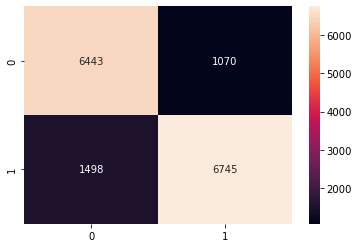

In [78]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred_sgd)
sns.heatmap(confusion_matrix(y_train, y_train_pred_sgd), annot=True,fmt='d')

In [79]:
#Performance measures for training dataset
from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score
print("Precision Score: ",precision_score(y_train, y_train_pred_sgd))
print("Recall Score: ",recall_score(y_train, y_train_pred_sgd))
print("F1 Score: ",f1_score(y_train, y_train_pred_sgd))
print("Accuracy Score: ",accuracy_score(y_train, y_train_pred_sgd))

Precision Score:  0.8630838131797824
Recall Score:  0.8182700473128716
F1 Score:  0.8400797110474529
Accuracy Score:  0.837014470677837


### Fine Tuning for Stochastic Gradient Descent

In [80]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import scipy.stats as stats
from sklearn.utils.fixes import loguniform

param_distribs = {
        "average": [True, False],
        "loss":['hinge', 'log_loss', 'modified_huber', 'squared_hinge',  'perceptron'],
        "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        "learning_rate":['constant', 'optimal', 'invscaling', 'adaptive'],
        "class_weight":[{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}],
        "eta0":[1, 10, 100],
        "penalty":['l2', 'l1', 'elasticnet']
    }
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
rnd_search_SGD = RandomizedSearchCV(sgd_clf, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='accuracy', random_state=42)
rnd_search_SGD.fit(X_train, y_train.values.ravel())

Wall time: 2.64 s


RandomizedSearchCV(cv=5, estimator=SGDClassifier(random_state=42),
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100, 1000],
                                        'average': [True, False],
                                        'class_weight': [{0: 0.5, 1: 0.5},
                                                         {0: 0.6, 1: 0.4},
                                                         {0: 0.4, 1: 0.6},
                                                         {0: 0.3, 1: 0.7}],
                                        'eta0': [1, 10, 100],
                                        'learning_rate': ['constant', 'optimal',
                                                          'invscaling',
                                                          'adaptive'],
                                        'loss': ['hinge', 'log_loss',
                                                 'modified_huber',
                                                 'squared_hinge',
                                                 'perceptron'],
                                        'penalty': ['l2', 'l1', 'elasticnet']},
                   random_state=42, scoring='accuracy')

In [81]:
cvres = pd.DataFrame(rnd_search_SGD.cv_results_).sort_values(by=['rank_test_score'])
for mean_score, params,rank in zip(cvres["mean_test_score"], cvres["params"],cvres["rank_test_score"]):
    print("Rank {}# - Score: {} - {}".format(rank, np.sqrt(mean_score), params))

Rank 1# - Score: 0.9071522370988951 - {'penalty': 'l1', 'loss': 'squared_hinge', 'learning_rate': 'constant', 'eta0': 10, 'class_weight': {1: 0.5, 0: 0.5}, 'average': True, 'alpha': 10}
Rank 2# - Score: 0.906067190289876 - {'penalty': 'elasticnet', 'loss': 'log_loss', 'learning_rate': 'optimal', 'eta0': 100, 'class_weight': {1: 0.5, 0: 0.5}, 'average': False, 'alpha': 0.0001}
Rank 3# - Score: 0.7233019967409637 - {'penalty': 'l1', 'loss': 'log_loss', 'learning_rate': 'invscaling', 'eta0': 100, 'class_weight': {1: 0.7, 0: 0.3}, 'average': False, 'alpha': 0.1}
Rank 4# - Score: 0.7168231352145172 - {'penalty': 'l1', 'loss': 'log_loss', 'learning_rate': 'constant', 'eta0': 100, 'class_weight': {1: 0.6, 0: 0.4}, 'average': False, 'alpha': 1000}
Rank 5# - Score: 0.7103745348021926 - {'penalty': 'l1', 'loss': 'perceptron', 'learning_rate': 'adaptive', 'eta0': 100, 'class_weight': {1: 0.6, 0: 0.4}, 'average': False, 'alpha': 0.1}
Rank 6# - Score: 0.7038231407485448 - {'penalty': 'l1', 'loss': 

In [82]:
rnd_search_SGD.best_estimator_

SGDClassifier(alpha=10, average=True, class_weight={0: 0.5, 1: 0.5}, eta0=10,
              learning_rate='constant', loss='squared_hinge', penalty='l1',
              random_state=42)

#### Evaluating on Test set

In [83]:
from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score

#Predict the response for test dataset
y_test_pred_sgd = rnd_search_SGD.best_estimator_.predict(X_test)
#y_test_pred_sgd = sgd_clf.predict(X_test)

print("Precision Score: ",precision_score(y_test, y_test_pred_sgd))
print("Recall Score: ",recall_score(y_test, y_test_pred_sgd))
print("F1 Score: ",f1_score(y_test, y_test_pred_sgd))
print("Accuracy Score: ",accuracy_score(y_test, y_test_pred_sgd))

Precision Score:  0.8190279214064116
Recall Score:  0.8646288209606987
F1 Score:  0.8412108337758896
Accuracy Score:  0.8292404340376928


In [84]:
from sklearn import metrics
#calculate AUC of model
auc_sgd = metrics.roc_auc_score(y_test, y_test_pred_sgd)
print(auc_sgd)

0.8275239913186727


In [85]:
cohen_score_sgd = cohen_kappa_score(y_test, y_test_pred_sgd)

In [86]:
acc_list.append(accuracy_score(y_test, y_test_pred_sgd))
auc_list.append(auc_sgd)
kappa_list.append(cohen_score_sgd)

## Logistic Regression

In [87]:
%%time
#logistic regression for targets 
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import cross_val_predict

log_clf = LogisticRegression(solver='saga', tol=1e-2, max_iter=200,
                              random_state=42)
log_clf.fit(X_train, y_train.values.ravel())

Wall time: 26.9 ms


LogisticRegression(max_iter=200, random_state=42, solver='saga', tol=0.01)

#### Evaluating on Train set

In [88]:
#Predict the response for train dataset
y_train_pred_log = log_clf.predict(X_train)
print("Logistic Regression score: ",log_clf.score(X_train, y_train))

Logistic Regression score:  0.8230515359228231


<AxesSubplot:>

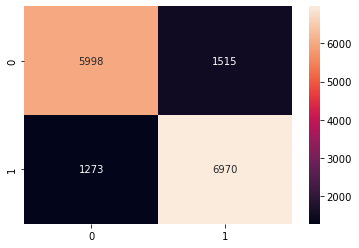

In [89]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion_matrix(y_train, y_train_pred_log)
sns.heatmap(confusion_matrix(y_train, y_train_pred_log), annot=True,fmt='d')

In [90]:
#Performance measures for training dataset
from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score
print("Precision Score: ",precision_score(y_train, y_train_pred_log))
print("Recall Score: ",recall_score(y_train, y_train_pred_log))
print("F1 Score: ",f1_score(y_train, y_train_pred_log))
print("Accuracy Score: ",accuracy_score(y_train, y_train_pred_log))

Precision Score:  0.8214496169711255
Recall Score:  0.8455659347325003
F1 Score:  0.8333333333333333
Accuracy Score:  0.8230515359228231


### Fine Tuning for Logistic Regression

In [91]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200,
                              random_state=42)
distributions = dict(C=uniform(loc=0, scale=4),
                     penalty=['l2'],
                     solver=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
rnd_search_LR = RandomizedSearchCV(logistic, distributions, random_state=42)
rnd_search_LR.fit(X_train, y_train.values.ravel())

Wall time: 1.01 s


RandomizedSearchCV(estimator=LogisticRegression(max_iter=200, random_state=42,
                                                solver='saga', tol=0.01),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001C0683A9520>,
                                        'penalty': ['l2'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   random_state=42)

In [92]:
cvres = pd.DataFrame(rnd_search_LR.cv_results_).sort_values(by=['rank_test_score'])
for mean_score, params,rank in zip(cvres["mean_test_score"], cvres["params"],cvres["rank_test_score"]):
    print("Rank {}# - Score: {} - {}".format(rank, np.sqrt(mean_score), params))

Rank 1# - Score: 0.9078167260215584 - {'C': 0.08233797718320979, 'penalty': 'l2', 'solver': 'lbfgs'}
Rank 2# - Score: 0.9077817002499292 - {'C': 0.7337391594646552, 'penalty': 'l2', 'solver': 'saga'}
Rank 2# - Score: 0.9077817002499292 - {'C': 0.7272998688284025, 'penalty': 'l2', 'solver': 'saga'}
Rank 4# - Score: 0.9076768366779415 - {'C': 1.8369955678634686, 'penalty': 'l2', 'solver': 'saga'}
Rank 5# - Score: 0.9075020001483654 - {'C': 1.49816047538945, 'penalty': 'l2', 'solver': 'saga'}
Rank 6# - Score: 0.9073970709646471 - {'C': 2.387400631785948, 'penalty': 'l2', 'solver': 'lbfgs'}
Rank 7# - Score: 0.9073620955724028 - {'C': 2.469926038510866, 'penalty': 'l2', 'solver': 'lbfgs'}
Rank 8# - Score: 0.9073271188319372 - {'C': 2.887995089067299, 'penalty': 'l2', 'solver': 'lbfgs'}
Rank 9# - Score: 0.9072921518404171 - {'C': 2.404460046972835, 'penalty': 'l2', 'solver': 'liblinear'}
Rank 10# - Score: 0.9072921407430938 - {'C': 0.6239780813448106, 'penalty': 'l2', 'solver': 'liblinear'}


In [93]:
rnd_search_LR.best_estimator_

LogisticRegression(C=0.08233797718320979, max_iter=200, random_state=42,
                   tol=0.01)

#### Evaluating on Test set

In [94]:
from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score

#Predict the response for test dataset
y_test_pred_log = rnd_search_LR.best_estimator_.predict(X_test)
#y_test_pred_log = log_clf.predict(X_test)

print("Precision Score: ",precision_score(y_test, y_test_pred_log))
print("Recall Score: ",recall_score(y_test, y_test_pred_log))
print("F1 Score: ",f1_score(y_test, y_test_pred_log))
print("Accuracy Score: ",accuracy_score(y_test, y_test_pred_log))

Precision Score:  0.8215767634854771
Recall Score:  0.8646288209606987
F1 Score:  0.8425531914893616
Accuracy Score:  0.8309537407195888


In [95]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_test_pred_log)
#calculate AUC of model
auc_log = metrics.roc_auc_score(y_test, y_test_pred_log)
print(auc_log)

0.8293203985043014


In [96]:
cohen_score_log = cohen_kappa_score(y_test, y_test_pred_log)

In [97]:
acc_list.append(accuracy_score(y_test, y_test_pred_log))
auc_list.append(auc_log)
kappa_list.append(cohen_score_log)

## XGBOOST

In [98]:
!pip install xgboost


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [99]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]

In [100]:
import xgboost as xgb
from xgboost import XGBClassifier

In [101]:
%%time
xgb_classifier = XGBClassifier(random_state=42)
xgb_classifier.fit(X_train, y_train.values.ravel())

Wall time: 663 ms


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42, ...)

#### Evaluating on Train set

In [102]:
#Predict the response for train dataset
y_train_pred_xgb = xgb_classifier.predict(X_train)
print("XGBoost score: ",xgb_classifier.score(X_train, y_train))

XGBoost score:  1.0


<AxesSubplot:>

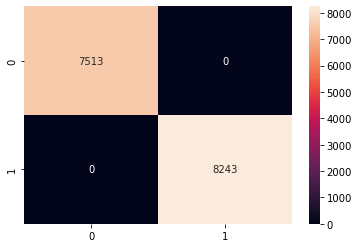

In [103]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion_matrix(y_train, y_train_pred_xgb)
sns.heatmap(confusion_matrix(y_train, y_train_pred_xgb), annot=True,fmt='d')


In [104]:
#Performance measures for training dataset

from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score
print("Precision Score: ",precision_score(y_train, y_train_pred_xgb))
print("Recall Score: ",recall_score(y_train, y_train_pred_xgb))
print("F1 Score: ",f1_score(y_train, y_train_pred_xgb))
print("Accuracy Score: ",accuracy_score(y_train, y_train_pred_xgb))

Precision Score:  1.0
Recall Score:  1.0
F1 Score:  1.0
Accuracy Score:  1.0


#### Fine Tuning for XGBoost

In [105]:
import warnings
warnings.filterwarnings('ignore')

In [106]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

xgb_classifier = XGBClassifier(random_state=42)

XG_distributions = dict(n_estimators=[100,200,300,400,500,600,700,800, 900, 1000],
                     max_depths = [2, 5, 10, 20],
                     learning_rate=[0.1,0.15,0.2,0.25,0.3],
                     colsample_bytree=[0.5,0.6,0.7,0.8,0.9,1],
                     subsample=[0.5,0.6,0.7,0.8,0.9,1],
                     grow_policy = ['depthwise', 'lossguide'],
                     booster = ['gbtree', 'gblinear', 'dart'],
                     sampling_method = ['uniform','gradient_based'])
rnd_search_XG = RandomizedSearchCV(xgb_classifier, XG_distributions, random_state=42)
rnd_search_XG.fit(X_train, y_train)

[21:55:45] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depths" } are not used.

[21:55:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depths" } are not used.

[21:55:50] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depths" } are not used.

[21:55:53] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depths" } are not used.

[21:55:56] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depths" } are not used.



RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                   param_distributions={'booster': ['gbtree', 'gblinear',
                                                    'dart'],
                                        'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             0.9, 1],
                                        'grow_policy': ['depthwise',
                                                        'lossguide'],
                                        'learning_rate': [0.1, 0.15, 0.2, 0.25,
                                                          0.3],
                                        'max_depths': [2, 5, 10, 20],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000],
                                        'sampling_method': ['uniform',
                                                            'gradient_based'],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1]},
                   random_state=42)

In [107]:
cvres = pd.DataFrame(rnd_search_XG.cv_results_).sort_values(by=['rank_test_score'])
for mean_score, params,rank in zip(cvres["mean_test_score"], cvres["params"],cvres["rank_test_score"]):
    print("Rank {}# - Score: {} - {}".format(rank, np.sqrt(mean_score), params))

Rank 1# - Score: 0.9963439332643715 - {'subsample': 0.8, 'sampling_method': 'uniform', 'n_estimators': 600, 'max_depths': 5, 'learning_rate': 0.25, 'grow_policy': 'depthwise', 'colsample_bytree': 0.8, 'booster': 'gbtree'}
Rank 2# - Score: 0.9959935355464774 - {'subsample': 0.8, 'sampling_method': 'uniform', 'n_estimators': 700, 'max_depths': 20, 'learning_rate': 0.2, 'grow_policy': 'depthwise', 'colsample_bytree': 0.8, 'booster': 'gbtree'}
Rank 3# - Score: 0.9957386445378571 - {'subsample': 0.6, 'sampling_method': 'uniform', 'n_estimators': 300, 'max_depths': 2, 'learning_rate': 0.25, 'grow_policy': 'depthwise', 'colsample_bytree': 0.6, 'booster': 'gbtree'}
Rank 4# - Score: 0.9947821127824779 - {'subsample': 1, 'sampling_method': 'gradient_based', 'n_estimators': 200, 'max_depths': 10, 'learning_rate': 0.1, 'grow_policy': 'lossguide', 'colsample_bytree': 0.5, 'booster': 'dart'}
Rank 5# - Score: 0.9083058475979163 - {'subsample': 0.6, 'sampling_method': 'gradient_based', 'n_estimators':

In [108]:
rnd_search_XG.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.25, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_depths=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=600,
              n_jobs=0, num_parallel_tree=1, predictor='auto', ...)

In [109]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]

In [110]:
y_test_pred_xgb = rnd_search_XG.best_estimator_.predict(X_test)

<AxesSubplot:>

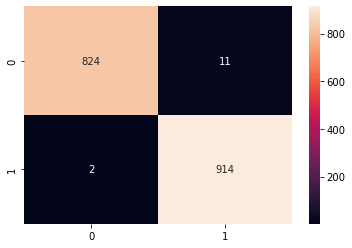

In [111]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, y_test_pred_xgb), annot=True,fmt='d')

In [112]:
#Performance measures for test dataset
from sklearn.metrics import precision_score, recall_score,f1_score 
print("Precision Score: ",precision_score(y_test, y_test_pred_xgb))
print("Recall Score: ",recall_score(y_test, y_test_pred_xgb))
print("F1 Score: ",f1_score(y_test, y_test_pred_xgb))
print("Accuracy Score: ",accuracy_score(y_test, y_test_pred_xgb))

Precision Score:  0.9881081081081081
Recall Score:  0.9978165938864629
F1 Score:  0.9929386203150461
Accuracy Score:  0.9925756710451171


In [113]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_test_pred_xgb)
#calculate AUC of model
auc_xgb = metrics.roc_auc_score(y_test, y_test_pred_xgb)
print(auc_xgb)


0.992321470595926


In [114]:
cohen_score_xgb = cohen_kappa_score(y_test, y_test_pred_xgb)

In [115]:
acc_list.append(accuracy_score(y_test, y_test_pred_xgb))
auc_list.append(auc_xgb)
kappa_list.append(cohen_score_xgb)

## Draw ROC curve and PR curve

### For Training Set

In [116]:
from sklearn.metrics import roc_curve

#Fuzzy Cognitive Map
fpr_FCM, tpr_FCM, thresholds_FCM = roc_curve(y_train, y_train_pred_fcm)

#------------------------------------------------------------------------------------------------#

#LightGBM Classifier
fpr_LGBM, tpr_LGBM, thresholds_LGBM = roc_curve(y_train, y_train_pred_lgbmc)

#------------------------------------------------------------------------------------------------#

#RIPPER (Repeated Incremental Pruning to Produce Error Reduction)
fpr_RIPPER, tpr_RIPPER, thresholds_RIPPER = roc_curve(y_train, y_train_pred_ripper)

#------------------------------------------------------------------------------------------------#

#Decision Tree
fpr_DT, tpr_DT, thresholds_DT = roc_curve(y_train, y_train_pred_dt)

#------------------------------------------------------------------------------------------------#

#K-Nearest Neighbour (KNN)
fpr_KNN, tpr_KNN, thresholds_KNN = roc_curve(y_train, y_train_pred_knn)

#------------------------------------------------------------------------------------------------#

#Artificial Neural Network
fpr_ANN, tpr_ANN, thresholds_ANN = roc_curve(y_train, model.predict(X_train))

#------------------------------------------------------------------------------------------------#

#Support Vector Machine
fpr_SVM, tpr_SVM, thresholds_SVM = roc_curve(y_train,  y_train_pred_svm)

#------------------------------------------------------------------------------------------------#

# Stochastic Gradient Descent
fpr_SGD, tpr_SGD, thresholds_SGD = roc_curve(y_train, y_train_pred_sgd)

#------------------------------------------------------------------------------------------------#

# Gaussian Naive Bayes
fpr_NB, tpr_NB, thresholds_NB = roc_curve(y_train, y_train_pred_nb)

#------------------------------------------------------------------------------------------------#

# Linear Regresison
fpr_LR, tpr_LR, thresholds_LR = roc_curve(y_train, y_train_pred_log)

#------------------------------------------------------------------------------------------------#

# XGBoost
fpr_XG, tpr_XG, thresholds_XG = roc_curve(y_train, y_train_pred_xgb)

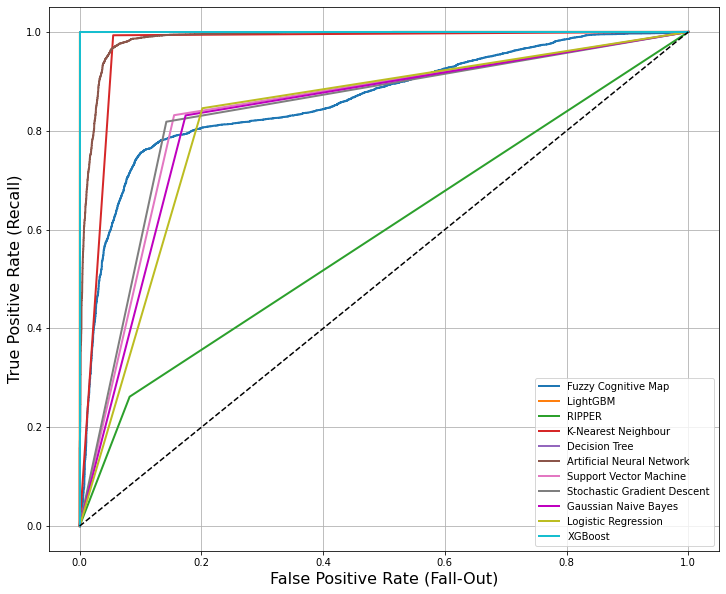

In [117]:
plt.figure(figsize=(12, 10))              

#Fuzzy Cognitive Map
plt.plot(fpr_FCM, tpr_FCM, linewidth=2, label="Fuzzy Cognitive Map")

#------------------------------------------------------------------------------------------------#

#LightGBM Classifier
plt.plot(fpr_LGBM, tpr_LGBM, linewidth=2, label="LightGBM")

#------------------------------------------------------------------------------------------------#

#RIPPER (Repeated Incremental Pruning to Produce Error Reduction)
plt.plot(fpr_RIPPER, tpr_RIPPER, linewidth=2, label="RIPPER")

#------------------------------------------------------------------------------------------------#

#K-Nearest Neighbour (KNN)
plt.plot(fpr_KNN, tpr_KNN, linewidth=2, label="K-Nearest Neighbour")

#------------------------------------------------------------------------------------------------#

#Decision Tree
plt.plot(fpr_DT, tpr_DT, linewidth=2, label="Decision Tree")

#------------------------------------------------------------------------------------------------#

#Artificial Neural Network
plt.plot(fpr_ANN, tpr_ANN, linewidth=2, label="Artificial Neural Network")

#------------------------------------------------------------------------------------------------#

#Support Vector Machine
plt.plot(fpr_SVM, tpr_SVM, linewidth=2, label="Support Vector Machine")

#------------------------------------------------------------------------------------------------#

# Stochastic Gradient Descent
plt.plot(fpr_SGD, tpr_SGD, linewidth=2, label="Stochastic Gradient Descent")

#------------------------------------------------------------------------------------------------#

# Gaussian Naive Bayes
plt.plot(fpr_NB, tpr_NB, "m-", linewidth=2, label="Gaussian Naive Bayes")

#------------------------------------------------------------------------------------------------#

# Linear Regresison
plt.plot(fpr_LR, tpr_LR, linewidth=2, label="Logistic Regression")

#------------------------------------------------------------------------------------------------#

# XGBoost
plt.plot(fpr_XG, tpr_XG, linewidth=2, label="XGBoost")

#------------------------------------------------------------------------------------------------#


# fpr_SGD_90 = fpr_SGD[np.argmax(tpr_SGD >= 0.9)]           

# plt.plot([fpr_SGD_90, fpr_SGD_90], [0., 0.9], "r:")
# plt.plot([0.0, fpr_SGD_90], [0.9, 0.9], "r:")  
# plt.plot([fpr_SGD_90], [0.9], "ro")   

# AUC curve
plt.plot([0, 1], [0, 1], 'k--')
# plt.axis([0, 1, 0, 1])



plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
plt.ylabel('True Positive Rate (Recall)', fontsize=16)

plt.legend(loc=4)
plt.grid(True)      
plt.show()

### For Test Set

In [118]:
from sklearn.metrics import roc_curve

#Fuzzy Cognitive Map
fpr_FCM, tpr_FCM, thresholds_FCM = roc_curve(y_test, y_test_pred_fcm)

#------------------------------------------------------------------------------------------------#

#LightGBM Classifier
fpr_LGBM, tpr_LGBM, thresholds_LGBM = roc_curve(y_test, y_test_pred_lgbmc)

#------------------------------------------------------------------------------------------------#

#RIPPER (Repeated Incremental Pruning to Produce Error Reduction)
fpr_RIPPER, tpr_RIPPER, thresholds_RIPPER = roc_curve(y_test, y_test_pred_ripper)

#------------------------------------------------------------------------------------------------#

#K-Nearest Neighbour (KNN)
fpr_KNN, tpr_KNN, thresholds_KNN = roc_curve(y_test, y_test_pred_knn)

#------------------------------------------------------------------------------------------------#

#Decision Tree
fpr_DT, tpr_DT, thresholds_DT = roc_curve(y_test, y_test_pred_dt)

#------------------------------------------------------------------------------------------------#

#Artificial Neural Network
fpr_ANN, tpr_ANN, thresholds_ANN = roc_curve(y_test, model.predict(X_test))

#------------------------------------------------------------------------------------------------#

#Support Vector Machine
fpr_SVM, tpr_SVM, thresholds_SVM = roc_curve(y_test, y_test_pred_svm)

#------------------------------------------------------------------------------------------------#

# Stochastic Gradient Descent
fpr_SGD, tpr_SGD, thresholds_SGD = roc_curve(y_test, y_test_pred_sgd)

#------------------------------------------------------------------------------------------------#

# Gaussian Naive Bayes
fpr_NB, tpr_NB, thresholds_NB = roc_curve(y_test, y_test_pred_nb)

#------------------------------------------------------------------------------------------------#

# Linear Regresison
fpr_LR, tpr_LR, thresholds_LR = roc_curve(y_test, y_test_pred_log)

#------------------------------------------------------------------------------------------------#

# XGBoost
fpr_XG, tpr_XG, thresholds_XG = roc_curve(y_test, y_test_pred_xgb)

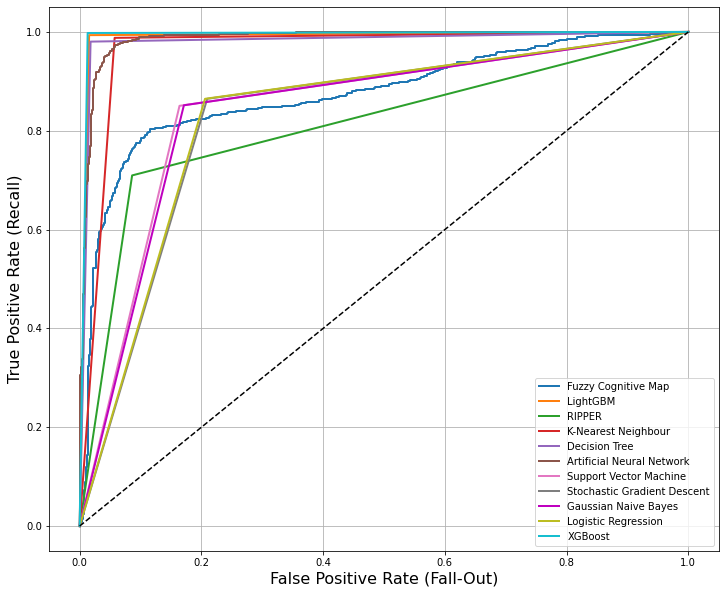

In [119]:
plt.figure(figsize=(12, 10))                                    

#Fuzzy Cognitive Map
plt.plot(fpr_FCM, tpr_FCM, linewidth=2, label="Fuzzy Cognitive Map")

#------------------------------------------------------------------------------------------------#

#LightGBM Classifier
plt.plot(fpr_LGBM, tpr_LGBM, linewidth=2, label="LightGBM")

#------------------------------------------------------------------------------------------------#

#RIPPER (Repeated Incremental Pruning to Produce Error Reduction)
plt.plot(fpr_RIPPER, tpr_RIPPER, linewidth=2, label="RIPPER")

#------------------------------------------------------------------------------------------------#

#K-Nearest Neighbour (KNN)
plt.plot(fpr_KNN, tpr_KNN, linewidth=2, label="K-Nearest Neighbour")

#------------------------------------------------------------------------------------------------#

#Decision Tree
plt.plot(fpr_DT, tpr_DT, linewidth=2, label="Decision Tree")

#------------------------------------------------------------------------------------------------#

#Artificial Neural Network
plt.plot(fpr_ANN, tpr_ANN, linewidth=2, label="Artificial Neural Network")


#------------------------------------------------------------------------------------------------#

#Support Vector Machine
plt.plot(fpr_SVM, tpr_SVM, linewidth=2, label="Support Vector Machine")


#------------------------------------------------------------------------------------------------#

# Stochastic Gradient Descent
plt.plot(fpr_SGD, tpr_SGD, linewidth=2, label="Stochastic Gradient Descent")


#------------------------------------------------------------------------------------------------#

# Gaussian Naive Bayes
plt.plot(fpr_NB, tpr_NB, "m-", linewidth=2, label="Gaussian Naive Bayes")

#------------------------------------------------------------------------------------------------#

# Linear Regresison
plt.plot(fpr_LR, tpr_LR, linewidth=2, label="Logistic Regression")


#------------------------------------------------------------------------------------------------#

# XGBoost
plt.plot(fpr_XG, tpr_XG, linewidth=2, label="XGBoost")

#------------------------------------------------------------------------------------------------#


# fpr_SGD_90 = fpr_SGD[np.argmax(tpr_SGD >= 0.9)]           

# plt.plot([fpr_SGD_90, fpr_SGD_90], [0., 0.9], "r:")
# plt.plot([0.0, fpr_SGD_90], [0.9, 0.9], "r:")  
# plt.plot([fpr_SGD_90], [0.9], "ro")   

# AUC curve
plt.plot([0, 1], [0, 1], 'k--')
# plt.axis([0, 1, 0, 1])



plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
plt.ylabel('True Positive Rate (Recall)', fontsize=16)

plt.legend(loc=4)
plt.grid(True)      
plt.show()

## The area under curve (AUC)
Through AUC you can summarize the performance of each classifier into a single measure when comparing different classifiers. Calculating the area under the ROC curve, abbreviated as AUC, is a typical method.


In [120]:
model_list = ['Fuzzy Cognitive Map', 'LightGBM', 'RIPPER', 'K-Nearest Neighbour' ,'Decision Tree', 'Artificial Neural Network', 'Support Vector Machine', 'Stochastic Gradient Descent', 'Gaussian Naive Bayes', 'Logistic Regression', 'XGBoost']

#accuracy and AUC
result_df = pd.DataFrame({'Model':model_list, 'Accuracy': acc_list, 'AUC': auc_list, 'Kappa':kappa_list})
result_df

,Model,Accuracy,AUC,Kappa
0,Fuzzy Cognitive Map,0.841805,0.875567,0.684318
1,LightGBM,0.989149,0.988940,0.978244
2,RIPPER,0.806967,0.811690,0.617041
3,K-Nearest Neighbour,0.966305,0.965253,0.932333
4,Decision Tree,0.981154,0.981193,0.962232
5,Artificial Neural Network,0.956025,0.986877,0.911801
6,Support Vector Machine,0.843518,0.843182,0.686365
7,Stochastic Gradient Descent,0.840662,0.840135,0.680523
8,Gaussian Naive Bayes,0.829240,0.827524,0.656822
9,Logistic Regression,0.830954,0.829320,0.660319


In [121]:
final_df = result_df.sort_values(by=['AUC'], ascending=False)
final_df

,Model,Accuracy,AUC,Kappa
10,XGBoost,0.992576,0.992321,0.985112
1,LightGBM,0.989149,0.988940,0.978244
5,Artificial Neural Network,0.956025,0.986877,0.911801
4,Decision Tree,0.981154,0.981193,0.962232
3,K-Nearest Neighbour,0.966305,0.965253,0.932333
0,Fuzzy Cognitive Map,0.841805,0.875567,0.684318
6,Support Vector Machine,0.843518,0.843182,0.686365
7,Stochastic Gradient Descent,0.840662,0.840135,0.680523
9,Logistic Regression,0.830954,0.829320,0.660319
8,Gaussian Naive Bayes,0.829240,0.827524,0.656822


# Explainability

## Global Explanations

### Leave One Feature Out (LOFO)
LOFO first evaluates the performance of the model with all the input features included, then iteratively removes one feature at a time, retrains the model, and evaluates its performance on a validation set. The mean and standard deviation (across the folds) of the importance of each feature is then reported.


In [122]:
!pip install lofo-importance
concat_df = pd.concat([X_train, y_train], axis=1)


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  0%|          | 0/6 [00:00<?, ?it/s]

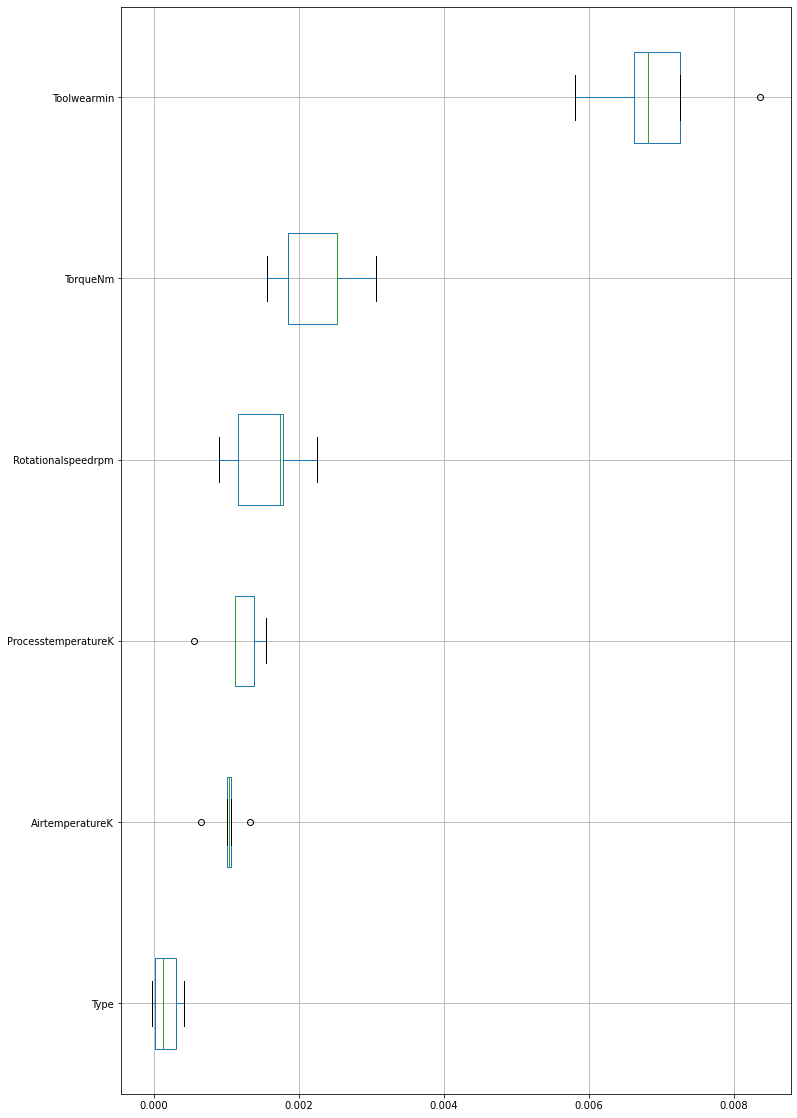

In [123]:
from sklearn.model_selection import KFold
from lofo import LOFOImportance, Dataset, plot_importance

# define the validation scheme
cv = KFold(n_splits=5, shuffle=True, random_state=0)

# set target
target = "Machine failure"

# define the binary target and the features
dataset = Dataset(df=concat_df, target=target, features=[col for col in concat_df.columns if col != target])

# define the validation scheme and scorer. The default model is LightGBM
lofo_imp = LOFOImportance(dataset, cv=cv, scoring="roc_auc")

# get the mean and standard deviation of the importances in pandas format
importance_df = lofo_imp.get_importance()

# plot the means and standard deviations of the importances
plot_importance(importance_df, figsize=(12, 20), kind="box")

## Local Explanations

In [124]:
#Find the observations' indexes that the model correctly predicted as faulty
#y: Expected values of the model's output
y=y_test;
true_positive_indexes = []
i=1;

#According to the chosen model
#For example, y_test_pred_lgbmc for LGBM Classifier
fcm_pred_class_test
y_test_pred_lgbmc
for k in range(0,len(y)):
    if (y.loc[k,'Machine failure']==int(fcm_pred_class_test[k])) and (y.loc[k,'Machine failure']==1):
        true_positive_indexes.append(k)
        i=i+1;

        
#Find the observations that the selected model correctly predicted as faulty based on the previous indexes
true_positive_observations = pd.DataFrame()
for k in range(0,len(true_positive_indexes)):
    new_row = pd.concat([original_X_test.loc[true_positive_indexes[k],:],y.loc[true_positive_indexes[k],:]], axis=0)
    true_positive_observations = true_positive_observations.append(new_row, ignore_index=True)

    
#Find the observations that the selected model correctly predicted correctly as faulty along with the failure modes

true_positive_observations_with_failure_modes = pd.DataFrame()
#for index1 in range(0,len(true_positive_observations)):
    #for index2 in range (0,len(ai4i2020_encoded_balanced)):
        #if true_positive_observations.loc[index1,:].equals(ai4i2020_encoded_balanced.loc[index2,"Type":"Machine failure"]) == True:
            #print(index1)
            #true_positive_observations_with_failure_modes = true_positive_observations_with_failure_modes.append(ai4i2020_encoded_balanced.loc[index2,:], ignore_index=True)
true_positive_observations_with_failure_modes = ai4i2020_encoded_balanced.join(true_positive_observations.set_index(['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]','Machine failure']), ['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]','Machine failure'], how='right')       
final_true_positive_observations_with_failure_modes = true_positive_observations_with_failure_modes.reset_index(drop=True)

display("Number of true positive predictions: " + str(len(final_true_positive_observations_with_failure_modes)))

number_of_TWF_failures_in_true_positive_predictions = 0
number_of_HDF_failures_in_true_positive_predictions = 0
number_of_PWF_failures_in_true_positive_predictions = 0
number_of_OSF_failures_in_true_positive_predictions = 0
number_of_random_failures_in_true_positive_predictions=0

for k in range(0,len(final_true_positive_observations_with_failure_modes)):
    if final_true_positive_observations_with_failure_modes.loc[k,"TWF"]==1: #if the failure mode is TWF
        number_of_TWF_failures_in_true_positive_predictions = number_of_TWF_failures_in_true_positive_predictions + 1;
    if final_true_positive_observations_with_failure_modes.loc[k,"HDF"]==1: #if the failure mode is HDF
        number_of_HDF_failures_in_true_positive_predictions = number_of_HDF_failures_in_true_positive_predictions + 1;
    if final_true_positive_observations_with_failure_modes.loc[k,"PWF"]==1: #if the failure mode is PWF
        number_of_PWF_failures_in_true_positive_predictions = number_of_PWF_failures_in_true_positive_predictions + 1;
    if final_true_positive_observations_with_failure_modes.loc[k,"OSF"]==1: #if the failure mode is OSF
        number_of_OSF_failures_in_true_positive_predictions = number_of_OSF_failures_in_true_positive_predictions + 1;
    if (final_true_positive_observations_with_failure_modes.loc[k,"Machine failure"]==1) and (final_true_positive_observations_with_failure_modes.loc[k,"TWF"]==0) and (final_true_positive_observations_with_failure_modes.loc[k,"HDF"]==0) and (final_true_positive_observations_with_failure_modes.loc[k,"PWF"]==0) and (final_true_positive_observations_with_failure_modes.loc[k,"OSF"]==0) and (final_true_positive_observations_with_failure_modes.loc[k,"RNF"]==0):
        number_of_random_failures_in_true_positive_predictions = number_of_random_failures_in_true_positive_predictions+1;

display("Number of TWF failures: " + str(number_of_TWF_failures_in_true_positive_predictions))
display("Number of HDF failures: " + str(number_of_HDF_failures_in_true_positive_predictions))
display("Number of PWF failures: " + str(number_of_PWF_failures_in_true_positive_predictions))
display("Number of OSF failures: " + str(number_of_OSF_failures_in_true_positive_predictions))
display("Number of RNF failures: " + str(number_of_random_failures_in_true_positive_predictions))

'Number of true positive predictions: 736'

'Number of TWF failures: 9'

'Number of HDF failures: 255'

'Number of PWF failures: 70'

'Number of OSF failures: 239'

'Number of RNF failures: 172'

In [125]:
#Interacitve Widget in order to see each true positive observation along with the failure modes

from IPython.display import display
from IPython.display import clear_output
from ipywidgets import Output
from ipywidgets import widgets


text = widgets.Text()
display(text)

out = widgets.Output()
display(out)

def handle_submit(sender):
    with out:
        clear_output()
        index = int(text.value)
        print(final_true_positive_observations_with_failure_modes.loc[index,:])
        print('\n')
        print("Dataset index for the above true positive observation (starting from 0 index): " + str(true_positive_indexes[index]))
        
text.on_submit(handle_submit)



Text(value='')

Output()

* TWF: The tool is replaced or fails after a random **Tool wear**
* HDF: If the **temperature** differential between the **air** and the **process** is less than 8.6 K while at the same time the tool's **rotational speed** is less than 1380 rpm
* PWF: If the product of **torque** and **rotational speed** in rad/sis less than 3500 W or greater than 9000 W
* OSF: The product of **tool wear**, and **torque**

In [126]:
!pip install explainerdashboard
from sklearn.ensemble import RandomForestClassifier
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
from explainerdashboard.datasets import titanic_survive, titanic_names
from explainerdashboard import InlineExplainer

#ExplainerDashboard(ClassifierExplainer(lgbmc_clf.fit(X_train, y_train.values.ravel()), X_test, y_test)).run()

explainer = ClassifierExplainer(lgbmc_clf.fit(X_train, y_train.values.ravel()), X_test, y_test)

InlineExplainer(explainer).shap.contributions_graph()
#ie.shap.contributions_graph()
#ie.classifier.model_stats()


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: model_output=='probability'. For LGBMClassifier shap values normally get calculated against X_background, but paramater X_background=None, so using X instead
Generating self.shap_explainer = shap.TreeExplainer(model, X, model_output='probability', feature_perturbation='interventional')...
Note: Shap interaction values will not be available. If shap values in probability space are not necessary you can pass model_output='logodds' to get shap values in logodds without the need for a background dataset and also working shap interaction values...
